## inference yolo-fastest model with one image

In [91]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import cv2
from  matplotlib import pyplot as plt
%matplotlib inline

import time
import colorsys
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.4.1'

In [1]:
img_path = "../example/person.jpg"
model_path = "../weights/yolo-fastest.h5"
class_path = "../configs/voc_classes.txt"
tflite_path = "../weights/yolo-fastest.tflite"

# 预选框
anchors = [[26, 48], [67, 84], [72, 175], [189, 126], [137, 236], [265, 259]]
anchors = np.array(anchors)
num_classes = 20
model_image_size = (320, 320)
conf_threshold, elim_grid_sense = 0.5, False
classes_path = "../configs/voc_classes.txt"

NameError: name 'np' is not defined

(424, 640, 3)


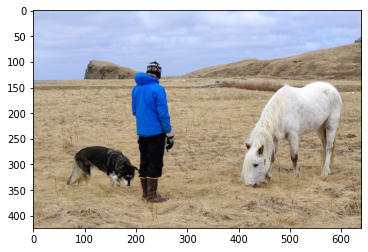

In [25]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_shape = img.shape[:-1]  # height, width
print(img.shape)
plt.imshow(img)
plt.show()

## 1. preprocess input data

In [26]:
img_resize = cv2.resize(img, model_image_size)
img_bn = img_resize / 255
img_bn = img_bn.astype("float32")
input_data = np.expand_dims(img_bn, axis=0)
input_data.shape

(1, 320, 320, 3)

## 2.1 load keras model

In [70]:
# load model
model = keras.models.load_model(model_path, compile=False)
yolo_output = model.predict(input_data)

# keep large-scale feature map is first
yolo_output = sorted(yolo_output, key=lambda x:len(x[0]))
yolo_output[0].shape, yolo_output[1].shape

((1, 10, 10, 75), (1, 20, 20, 75))

## 2.2 load tflite model

In [138]:
class YoloFastest(object):
    def __init__(self, landmark_model_path):
        self.interp_joint = tf.lite.Interpreter(landmark_model_path)
        self.interp_joint.allocate_tensors()

        # input & input shape
        self.in_idx_joint = self.interp_joint.get_input_details()[0]['index']
        # [b, h, w, c]: [1, 320, 320, 3]
        self.input_shape = self.interp_joint.get_input_details()[0]['shape']

        # output
        self.out_idx = self.interp_joint.get_output_details()[0]['index']
        self.out_idx2 = self.interp_joint.get_output_details()[1]['index']


    def predict_joint(self, img_norm):
        """inference tflite model"""
        self.interp_joint.set_tensor(self.in_idx_joint, img_norm.reshape(self.input_shape))
        self.interp_joint.invoke()
        output = self.interp_joint.get_tensor(self.out_idx)
        output2 = self.interp_joint.get_tensor(self.out_idx2)
        return [output, output2]


    def __call__(self, img):
        yolo_output = self.predict_joint(img)
        return yolo_output

In [139]:
yolo_fastest = YoloFastest(tflite_path)
yolo_output = yolo_fastest(input_data)
yolo_output[1].shape

(1, 20, 20, 75)

## 3. yolo decode

In [140]:
def yolo_decode(prediction, anchors, num_classes, input_dims, scale_x_y=None, use_softmax=False):
    '''Decode final layer features to bounding box parameters.'''
    num_anchors = len(anchors)  # anchors *3
    grid_size = prediction.shape[1:3]  # 10*10 grids in a image

    # shape: (10*10*3, 25); (20*20*3, 25)
    prediction = np.reshape(prediction,
                            (grid_size[0] * grid_size[1] * num_anchors, num_classes + 5))

    # generate x_y_offset grid map
    x_y_offset = [[[j, i]] * num_anchors for i in range(grid_size[0]) for j in range(grid_size[0])]
    # shape: (10*10*3, 2)
    x_y_offset = np.array(x_y_offset).reshape(grid_size[0] * grid_size[1] * num_anchors , 2)
#     print(f"x_y_offset shape： {x_y_offset.shape}")

    # sigmoid: expit(x) = 1 / (1 + exp(-x))
    x_y_tmp = 1 / (1 + np.exp(-prediction[..., :2]))
    # shape: (300, 2)
    box_xy = (x_y_tmp + x_y_offset) / np.array(grid_size)[::-1]

    # Log space transform of the height and width
    # anchors = np.array(anchors.tolist()*(grid_size[0] * grid_size[1]))
    anchors_expand = np.tile(anchors, (grid_size[0]*grid_size[1], 1))
    # shape: (300, 2)
    box_wh = (np.exp(prediction[..., 2:4]) * anchors_expand) / np.array(input_dims)[::-1]

    # sigmoid function; objectness score
    # shape: (300, 1)
    objectness = 1 / (1 + np.exp(-prediction[..., 4]))
    objectness = np.expand_dims(objectness, axis=-1)

    # sigmoid function
    # shape: (300, 20)
    if use_softmax:
        class_scores = np.exp(prediction[..., 5:]) / np.sum(np.exp(prediction[..., 5:]))
    else:
        class_scores = 1 / (1 + np.exp(-prediction[..., 5:]))

    return np.concatenate([box_xy, box_wh, objectness, class_scores], axis=-1)

In [141]:
def yolo3_decode(predictions, anchors, num_classes, input_dims, elim_grid_sense=False):
    """
    YOLOv3 Head to process predictions from YOLOv3 models

    :param num_classes: Total number of classes
    :param anchors: YOLO style anchor list for bounding box assignment
    :param input_dims: Input dimensions of the image
    :param predictions: A list of three tensors with shape (N, 19, 19, 255), (N, 38, 38, 255) and (N, 76, 76, 255)
    :return: A tensor with the shape (N, num_boxes, 85)
    """
    # weather right dims of prediction outputs
    assert len(predictions) == len(anchors)//3, 'anchor numbers does not match prediction.'

    if len(predictions) == 3: # assume 3 set of predictions is YOLOv3
        anchor_mask = [[6,7,8], [3,4,5], [0,1,2]]
        scale_x_y = [1.05, 1.1, 1.2] if elim_grid_sense else [None, None, None]
    elif len(predictions) == 2: # 2 set of predictions is YOLOv3-tiny or yolo-fastest
        anchor_mask = [[3,4,5], [0,1,2]]
        scale_x_y = [1.05, 1.05] if elim_grid_sense else [None, None]
    else:
        raise ValueError('Unsupported prediction length: {}'.format(len(predictions)))

    results = []
    for i, prediction in enumerate(predictions):
        results.append(yolo_decode(prediction, anchors[anchor_mask[i]], num_classes, input_dims, 
                                   scale_x_y=scale_x_y[i], use_softmax=False))

    return np.concatenate(results, axis=0)

predictions_bn = yolo3_decode(yolo_output, anchors, num_classes, model_image_size, elim_grid_sense)
predictions_bn.shape

(1500, 25)

## 4. Post-processing output

In [142]:
def nms_boxes(boxes, classes, scores, iou_threshold, confidence=0.1):
    # center_xy, box_wh
    x = boxes[:, 0]
    y = boxes[:, 1]
    w = boxes[:, 2]
    h = boxes[:, 3]
    xmin, ymin = x - w/2, y - h/2
    xmax, ymax = x + w/2, y + h/2

    order = np.argsort(scores)[::-1]
    all_areas = w * h
    
    keep_index = []  # valid index
    
    while order.size > 0:
        keep_index.append(order[0])  # 永远保留置信度最高的索引
        # 最大置信度的左上角坐标分别与剩余所有的框的左上角坐标进行比较，分别保存较大值
        inter_xmin = np.maximum(xmin[order[0]], xmin[order[1:]])
        inter_ymin = np.maximum(ymin[order[0]], ymin[order[1:]])
        inter_xmax = np.minimum(xmax[order[0]], xmax[order[1:]])
        inter_ymax = np.minimum(ymax[order[0]], ymax[order[1:]])

        # 当前类所有框的面积
        # x1=3,x2=5,习惯上计算x方向长度就是x=3、4、5这三个像素，即5-3+1=3，
        # 而不是5-3=2，所以需要加1
        inter_w = np.maximum(0., inter_xmax - inter_xmin + 1)
        inter_h = np.maximum(0., inter_ymax - inter_ymin + 1)
        inter = inter_w * inter_h

        #计算重叠度IOU：重叠面积/（面积1+面积2-重叠面积）
        iou = inter / (all_areas[order[0]] + all_areas[order[1:]] - inter)

        # 计算iou的时候, 并没有计算第一个数, 所以索引对应的是order[1:]之后的, 所以需要加1
        indexs = np.where(iou <= iou_threshold)[0]
        order = order[indexs+1]

    keep_boxes = boxes[keep_index]
    keep_classes = classes[keep_index]
    keep_scores = scores[keep_index]
    
    return keep_boxes, keep_classes, keep_scores

In [143]:
def yolo_handle_predictions(predictions, image_shape, confidence=0.1, iou_threshold=0.4, use_cluster_nms=False, use_wbf=False):
    boxes = predictions[..., :4]
    box_confidences = np.expand_dims(predictions[..., 4], -1)
    box_class_probs = predictions[..., 5:]

    # filter boxes with confidence threshold
    box_scores = box_confidences * box_class_probs
    box_classes = np.argmax(box_scores, axis=-1)  # max probability index(class)
    box_class_scores = np.max(box_scores, axis=-1)  # max scores
    pos = np.where(box_class_scores >= confidence)

    boxes = boxes[pos]
    classes = box_classes[pos]
    scores = box_class_scores[pos]
    
    # rescale predicition boxes back to original image shap
    image_shape = image_shape[::-1]  # width, height
    boxes[..., :2] *= image_shape  # xy
    boxes[..., 2:] *= image_shape  # wh
    
    n_boxes, n_classes, n_scores = nms_boxes(boxes, classes, scores, iou_threshold, confidence=confidence)

    if n_boxes.size:
        classes = n_classes.astype('int32')
        return n_boxes, classes, n_scores
    else:
        return [], [], []
    
confidence, iou_threshold = 0.5, 0.4
boxes, classes, scores = yolo_handle_predictions(predictions_bn, img_shape,
                                                 confidence=confidence,
                                                 iou_threshold=iou_threshold)
boxes, classes, scores

(array([[230.91689205, 224.80064464,  91.20153522, 275.43083876],
        [503.73781204, 230.45997097, 228.28697515, 201.97974626],
        [138.42546749, 308.61868167, 136.89373398,  80.63381445]]),
 array([14, 16, 11], dtype=int32),
 array([0.99186923, 0.9760349 , 0.96656267]))

In [144]:
def yolo_adjust_boxes(boxes, img_shape):
    '''
    change box format from (x,y,w,h) top left coordinate to
    (xmin,ymin,xmax,ymax) format
    '''
    if boxes is None or len(boxes) == 0:
        return []

    image_shape = np.array(img_shape, dtype='float32')
    height, width = image_shape

    adjusted_boxes = []
    for box in boxes:
        x, y, w, h = box

        xmin = x - w/2
        ymin = y - h/2
        xmax = x + w/2
        ymax = y + h/2

        ymin = max(0, np.floor(ymin + 0.5).astype('int32'))
        xmin = max(0, np.floor(xmin + 0.5).astype('int32'))
        ymax = min(height, np.floor(ymax + 0.5).astype('int32'))
        xmax = min(width, np.floor(xmax + 0.5).astype('int32'))
        adjusted_boxes.append([xmin,ymin,xmax,ymax])

    return np.array(adjusted_boxes,dtype=np.int32)

boxes_real = yolo_adjust_boxes(boxes, img_shape)
boxes_real

array([[185,  87, 277, 363],
       [390, 129, 618, 331],
       [ 70, 268, 207, 349]], dtype=int32)

## 5. draw predictions in image

In [145]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.read().split()
    return class_names


def get_colors(class_names):
    # Generate colors for drawing bounding boxes.
    hsv_tuples = [(x / len(class_names), 1., 1.)
                  for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    np.random.seed(10101)  # Fixed seed for consistent colors across runs.
    np.random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    np.random.seed(None)  # Reset seed to default.
    return colors

class_names = get_classes(classes_path)
colors = get_colors(class_names)
len(class_names)

20

In [146]:
def draw_label(image, text, color, coords):
    font = cv2.FONT_HERSHEY_PLAIN
    font_scale = 1.
    (text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]

    padding = 5
    rect_height = text_height + padding * 2
    rect_width = text_width + padding * 2

    (x, y) = coords

    cv2.rectangle(image, (x, y), (x + rect_width, y - rect_height), color, cv2.FILLED)
    cv2.putText(image, text, (x + padding, y - text_height + padding), font,
                fontScale=font_scale,
                color=(255, 255, 255),
                lineType=cv2.LINE_AA)

    return image

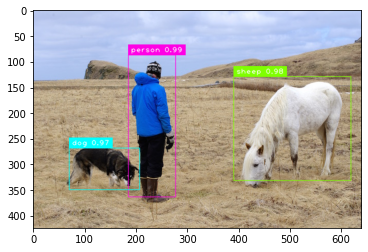

In [147]:
def draw_boxes(image, boxes, classes, scores, class_names, colors, show_score=True):
    if boxes is None or len(boxes) == 0:
        return image
    if classes is None or len(classes) == 0:
        return image

    for box, cls, score in zip(boxes, classes, scores):
        xmin, ymin, xmax, ymax = map(int, box)

        class_name = class_names[cls]
        if show_score:
            label = '{} {:.2f}'.format(class_name, score)
        else:
            label = '{}'.format(class_name)
#         print(label, (xmin, ymin), (xmax, ymax))

        # if no color info, use black(0,0,0)
        if colors == None:
            color = (0,0,0)
        else:
            color = colors[cls]
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 1, cv2.LINE_AA)
        image = draw_label(image, label, color, (xmin, ymin))

    return image


img_copy = img.copy()
image_array = draw_boxes(img_copy, boxes_real, classes, scores, class_names, colors)
plt.imshow(image_array)
plt.show()